In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import toeplitz
from scipy.linalg import solve
#For pretty printing numpy arrays

In [91]:
def gaussvector(mu, C, m):
    '''
    Generates a Gaussian random vector of length m given mean and covariance
    Arg:
        mu: Mean of random variable in the vector
        C: Covariance matrix of the random vector (nXn)
        m: The number of random gaussian vectors
    Returns:
        x: An n X m matrix of gaussian random vectors
    '''
    #Sets random seed for reproducibility
    np.random.seed(45)
    
    if (min(np.shape(C))==1 or len(np.shape(C))==1):
        #Checks if C is a vector and if so converts it to symmetric matrix
        C = toeplitz(C)
    
    n = np.shape(C)[1]
    
    if np.size(mu) == 1:
        mu = mu*np.ones((n,1))

    u,s,vh = np.linalg.svd(C)
    v = vh.T
        
    x = v@(np.diag(s)**0.5)@np.random.randn(n,m)+(mu@np.ones((1,m)))
    
    return x

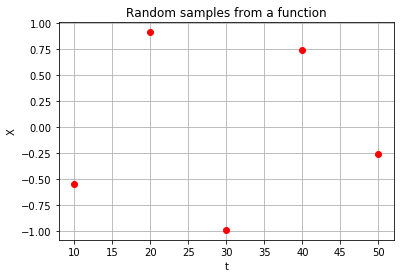

In [4]:
y_indx = [10, 20, 30, 40, 50]
y = np.sin(y_indx)

plt.plot(y_indx,y,'ro')
plt.grid()
plt.title("Random samples from a function")
plt.xlabel("t")
plt.ylabel("X")
plt.show()

In [5]:
#Let's try to generate the Prior distribution of Gaussian process
a = 1
T = 10
s = 3
n = np.arange(0,51)
Cxx = 1/(1+a*n**2)
X = gaussvector(0, Cxx,s)
print(n)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50]


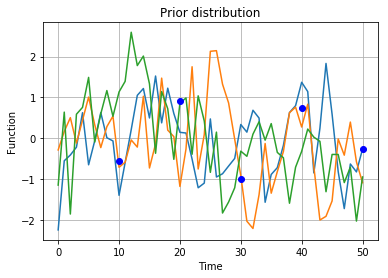

In [6]:
plt.plot(n,X)
plt.plot(y_indx,y,'bo')
plt.title("Prior distribution")
plt.xlabel('Time')
plt.ylabel('Function')
plt.grid()
plt.show()

Here we see that plotting just the prior without any information about what we have observed results in sample paths that do not intersect with our points.

We will now construct our mean and covaraince for the posterior distribution and then generate sample paths from that to get sample paths that incorporate our "training" data.

## Finding $f_{w|y}$

So we have a stationary discrete Gaussian Process $X_{n}$ and we want to consider a sequence generated from this gaussian process ${X_{n}: n = 1, ...., T}$ with $E[X_{n}] = 0$ and covariance function $C_{X}[k] = E[X_{n}X_{n+k}]$. 

Now we have observed subsamples $X_{T},X_{2T},...,X_{mT}$ and we put this into a vector $Y = [X_{T},X_{2T},...,X_{mT}]$. Now lets consider the vector $W = [X_{0}, X_{1}, ...., X_{T-1}, X_{T+1},..., X{mT-1}]$ this has all the values from the generated sequence of the Gaussian process $X_{n}$ without any of the elements from $Y$.

Therefore $X = [W, Y]$ and thus $W$ and $Y$ are jointly Gaussian. Since this is the case we want to find $C_{w|y}$ and $\mu_{w|y}$ in order to generate gaussian random vectors $W$ and then impute the missing values into $W$ from $Y$ vector to get the "filled in" random vector $X$. We can find $C_{w|y}$ from theorem 1 and we can find $C_{wy}$ since all the elements of $w$ and $y$ are actually from the same Gaussian process.

In [113]:
def xsamplepath(y, T, a, s):
    '''
    This function takes in a vector y of sampled from a Gaussian random vector coming from a Gaussian process
    with 0 mean and cov[k] = 1/(1+ak^2).
    
    It returns s Gaussian random vectors X which are the posterior distribution
    '''

    
    #We need to find C_w|y and u_w|y
    #Get number of samples
    m = len(y)
    
    #Generate list of time indices for W vector
    w_samps = [0]
    w_samps_fromOne = np.asarray([t for t in n if t%T != 0]).T
    w_samps = np.append(w_samps,w_samps_fromOne)
    
    #Generate list of time samples
    y_indx = np.arange(T, m*T+T, T)
    
    y_indx = y_indx.reshape((1,np.size(y_indx)))
    Y_SAMPS = np.ones((np.size(w_samps),1)) @ y_indx
    
    w_samps = w_samps.reshape((np.size(w_samps),1))
    W_SAMPS = w_samps @ np.ones((1, np.size(y_indx)))
    
    #Cwy_taus generates a matrix where element a_ij = y_i-w_i
    Cwy_taus = np.abs(W_SAMPS-Y_SAMPS)
    Cwy = 1/(1+a*Cwy_taus**2)
    
    y = np.asarray(y).reshape((len(y),1))
    
    Cyy = 1/(1+a*(y_indx-T)**2)
    Cyy = toeplitz(Cyy)

   # print("Cyy is \n{}".format(Cyy))
    
    mu_w_y = Cwy @ np.linalg.inv(Cyy) @ y
    
    Cww = 1/(1+a*w_samps**2)
    Cww = toeplitz(Cww)
    
    #Covaraince of w conditioned on y
    C_w_y = Cww - Cwy @ np.linalg.inv(Cyy) @ Cwy.T
    
    W = gaussvector(mu_w_y,C_w_y,s)
    
    #Interpolates the values of from y vector back into W
    X = X = np.zeros((s,m*T+1))
    
    b = 0
    for i in range(0,m*T+1):
        if i%10 == 0 and i != 0:
            samp = (i//10)-1
            X[:,i] = y[samp]
            b = b+1
        else:
            X[:,i] = W[(i-b),:]
    
    return X, W, w_samps

In [133]:
s=20
a1=1
X1, W1, w1_indices = xsamplepath(y, T, a1, s)

a2 = 1e-1
X2,W2, w2_indices = xsamplepath(y, T, a2, s)

a3 = 1e-2
X3, W3, w3_indices = xsamplepath(y, T, a3, s)

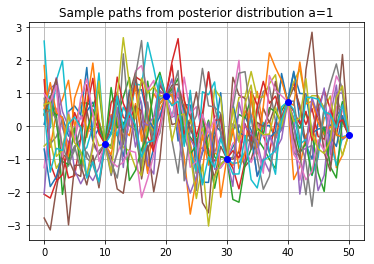

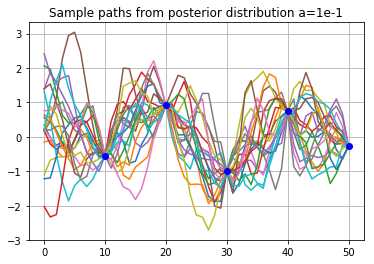

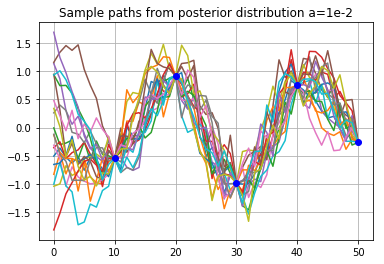

In [140]:
plt.plot(n, X1.T)
plt.plot(y_indx, y.reshape((1,len(y))),'bo')
plt.grid()
plt.title('Sample paths from posterior distribution a=1')
plt.show()

plt.plot(n, X2.T)
plt.plot(y_indx, y.reshape((1,len(y))),'bo')
plt.title('Sample paths from posterior distribution a=1e-1')
plt.grid()
plt.show()

plt.plot(n, X3.T)
plt.plot(y_indx, y.reshape((1,len(y))),'bo')
plt.title('Sample paths from posterior distribution a=1e-2')
plt.grid()
plt.show()